# Training CNN for imaging fluid flow with streaks analysis
    

## Prepatory steps

Get some includes first and define convenience routines

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy import random

%matplotlib inline

print(torch.__version__)

1.0.1.post2


Fix random seed to make sure we get reproducible results. This can be removed at production stage.

In [36]:
my_seed = 12345
torch.manual_seed(my_seed)

Load data and preprocess

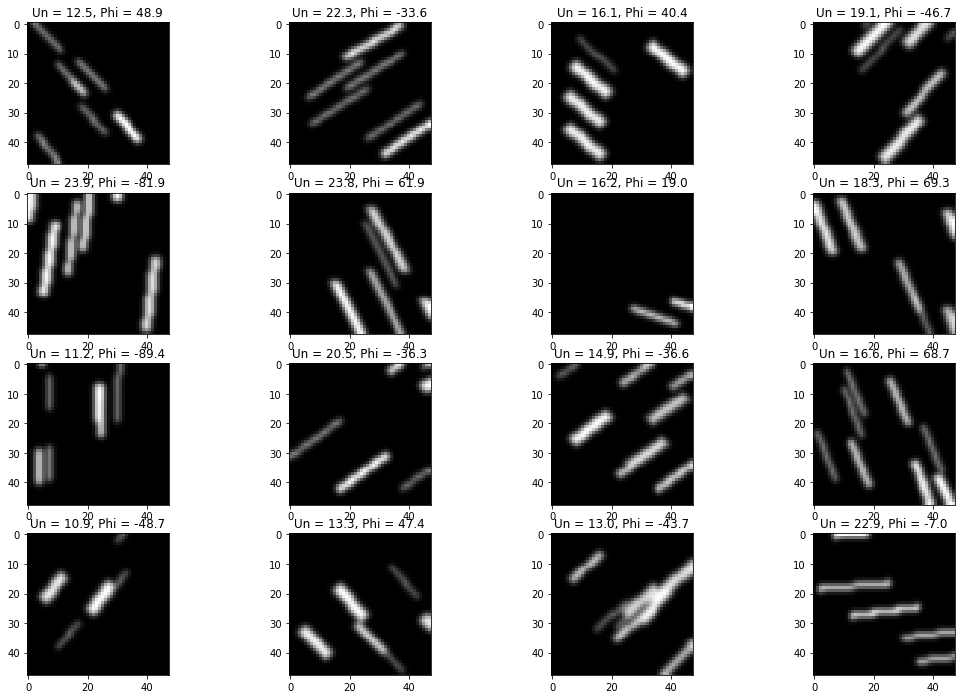

In [37]:
h5f = h5py.File('data/train_val_sets.h5','r')

images = np.array(h5f['images'], dtype = np.float32)
Un = h5f['Un']
Phi = h5f['Phi']
windowSize = h5f['windowSize']

trainImages, validationImages, trainData, validationData = \
    train_test_split(images, np.column_stack((Un, Phi)), test_size=0.25, random_state=my_seed, shuffle = False)

indices = random.randint(0, len(trainImages), 16)

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.gray()
    plt.imshow(trainImages[indices[i],0,:,:])
    ax.set_title("Un = %.1f, Phi = %.1f" % (trainData[indices[i],0], trainData[indices[i],1]))
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
plt.show()

Preprocess data

((14400, 2), (4800, 2))


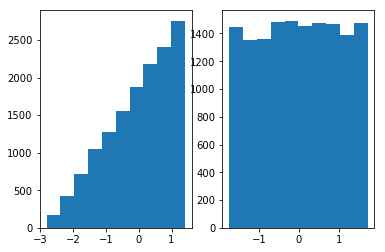

In [38]:
trainImages /= 255
validationImages /= 255

scaler = StandardScaler()
trainData = scaler.fit_transform(trainData)
validationData = scaler.transform(validationData)

print((trainData.shape, validationData.shape))

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.hist(trainData[:,0]);
ax = fig.add_subplot(1,2,2)
plt.hist(trainData[:,1]);

## Creating and training of a CNN

Define some global settings

In [39]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


Load network architecture we will use

In [40]:
from CNN_architectures import StreaksCNN

Convert data into pytorch compatible format

In [41]:
params = {'batch_size': 192,
          'shuffle': True,
          'num_workers': 0}

xtrain = torch.from_numpy(trainImages)
ytrain = torch.from_numpy(trainData)

train_dataset = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(train_dataset, **params)

#for batch_idx, (x, y) in enumerate(train_loader):
#    print(x.shape, y.shape)

xvalidation = torch.from_numpy(validationImages)
yvalidation = torch.from_numpy(validationData)

validation_dataset = TensorDataset(xvalidation, yvalidation)
validation_loader = DataLoader(validation_dataset, **params)

Perform training

In [42]:
learning_rate = 3e-4

net = StreaksCNN(winSz = windowSize, filtSz = 5, convPad = 2)
net.to(device)
loss = torch.nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

n_epochs = 5
n_batches = len(train_loader)

# Time for printing
training_start_time = time.time()

train_loss_log = np.zeros(n_epochs)
validation_loss_log = np.zeros(n_epochs)

# Loop for n_epochs
for epoch in range(n_epochs):
        
    print_every = n_batches // 5
    start_time = time.time()
    total_train_loss = 0
        
    net.train()
    for i, data in enumerate(train_loader, 0):
        # Get inputs
        inputs, labels = data
            
        # Wrap them in a Variable object
        #inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)
                
        # Set the parameter gradients to zero
        optimizer.zero_grad()
            
        # Forward pass, backward pass, optimize
        outputs = net(inputs)
        
        loss_size = loss(outputs, labels)
        loss_size.backward()
        optimizer.step()
            
        total_train_loss += loss_size.item()
            
        #if (i + 1) % (print_every + 1) == 0:
        #    print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
        #          epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
        
        # Reset time
        start_time = time.time()
    
    # At the end of the epoch, do a pass on the validation set
    net.eval()
    total_val_loss = 0
    for inputs, labels in validation_loader:
        # Wrap tensors in Variables
        #inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)
            
        # Forward pass
        val_outputs = net(inputs)
        val_loss_size = loss(val_outputs, labels)
        total_val_loss += val_loss_size.item()
                
    train_loss_log[epoch] = np.sqrt(total_train_loss / len(train_dataset))
    validation_loss_log[epoch] = np.sqrt(total_val_loss / len(validation_dataset))
    
    print("Train RMSE = {:.2f}, Validation RMSE = {:.2f}".format(train_loss_log[epoch], validation_loss_log[epoch]))
        
print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

Train RMSE = 1.11, Validation RMSE = 1.45
Train RMSE = 0.84, Validation RMSE = 0.75
Train RMSE = 0.74, Validation RMSE = 0.68
Train RMSE = 0.69, Validation RMSE = 0.67
Train RMSE = 0.65, Validation RMSE = 0.62
Training finished, took 42.01s


Once the network is trained, let us display some learning statistics and model information

Text(0, 0.5, 'RMSE')

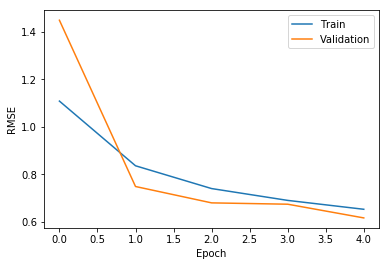

In [43]:
fig = plt.figure()
plt.plot(train_loss_log, '')
plt.plot(validation_loss_log)
plt.legend(('Train', 'Validation'))
plt.xlabel('Epoch')
plt.ylabel('RMSE')

Print model summary

In [44]:
print(net)

StreaksCNN(
  (cnn_part): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout2d(p=0.2)
  (fc1): Linear(in_features=1152, out_feat

Apply final network to the validation data set and check accuracy on Un and phi independently

In [45]:
params = {'batch_size': 192,
          'shuffle': False,
          'num_workers': 0}

test_loader = DataLoader(validation_dataset, **params)

ypredicted = np.empty(shape=(0,2))

net.eval()
for inputs, outputs in test_loader:
    # Wrap tensors in Variables
    inputs, outputs = inputs.to(device), outputs.to(device)
            
    # Forward pass
    val_outputs = net(inputs)
    
    ypredicted = np.concatenate((ypredicted, val_outputs.data.numpy()))
    
ypredicted = scaler.inverse_transform(ypredicted)
ytruth = scaler.inverse_transform(validationData)
yresiduals = ypredicted - ytruth
yrmse = np.sqrt(np.mean(yresiduals**2, axis = 0))

print('RMSE on Un = ', yrmse[0], ', RMSE on phi = ', yrmse[1])

thrNorm = 1;
thrPhi = 18; 
numCorrectNorm = np.sum(np.abs(yresiduals[:,0]) < thrNorm)
numCorrectPhi = np.sum(np.abs(yresiduals[:,1]) < thrPhi)

accuracy = np.array([numCorrectNorm, numCorrectPhi])/len(yresiduals)
print(accuracy)

RMSE on Un =  2.845462200717215 , RMSE on phi =  18.294908560601314
[0.27583333 0.84395833]


Save trained network and all additional training data

In [46]:
file_net = 'test'

torch.save(net.state_dict(), ('networks/%s.pytorch' % file_net))

trainImages *= 255
validationImages *= 255

h5f = h5py.File(('networks/%s_data.h5' % file_net), 'w')
h5f.create_dataset('RMSE', data=yrmse, compression="gzip", compression_opts=6)
h5f.create_dataset('trainImages', data=trainImages, compression="gzip", compression_opts=6)
h5f.create_dataset('validationImages', data=validationImages, compression="gzip", compression_opts=6)
h5f.create_dataset('trainData', data=scaler.inverse_transform(trainData))
h5f.create_dataset('validationData', data=scaler.inverse_transform(validationData))
h5f.create_dataset('scale', data=scaler.scale_)
h5f.create_dataset('mean', data=scaler.mean_)
h5f.create_dataset('rmse_training', data=train_loss_log)
h5f.create_dataset('rmse_validation', data=validation_loss_log)
h5f.create_dataset('windowSize', data=windowSize)

h5f.close()